In [15]:
from google.colab import drive
drive.mount('/content/drive')
path="/content/drive/MyDrive/CIS680/hw3/data/"

!pip install h5py
import numpy as np
import h5py
import torch
import torchvision
import torch.nn as nn
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

print("The device is",device)

f=h5py.File(path+"/hw3_mycocodata_mask_comp_zlib.h5")
mask=f['data']
f=h5py.File(path+"/hw3_mycocodata_img_comp_zlib.h5")
image=f['data']
bboxes=np.load(path+"/hw3_mycocodata_bboxes_comp_zlib.npy",allow_pickle=True)
labels=np.load(path+"/hw3_mycocodata_labels_comp_zlib.npy",allow_pickle=True)

count=0
gt_mask_indices=[]

for number in labels:
  mask_list=[]
  for each_count in range(len(number)):
    mask_list.append(count)
    count=count+1
  gt_mask_indices.append(mask_list)
gt_mask_list=[]

for mask_indices in gt_mask_indices:
  gt_mask_list.append(mask[mask_indices])


subset_images=image[:10]
subset_masks=gt_mask_list[:10]
subset_bounding_boxes=bboxes[:10]
subset_labels=labels[:10]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The device is cuda:0


In [16]:
from torchvision import transforms
img_vis_transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229,0.224,0.225)),transforms.Resize((800,1066)),transforms.Pad(padding=(11,0), fill=0, padding_mode='constant')])
mask_transforms=transforms.Compose([transforms.ToTensor(),transforms.Resize((800,1066)),transforms.Pad(padding=(11,0), fill=0, padding_mode='constant')])
import torch
from torch.utils.data import Dataset
class SOLO_Dataset(Dataset):
  def __init__(self, bbox_list,gt_mask_list,image,label_list,transform=None):

          self.bbox_list = bbox_list
          self.gt_mask_list=gt_mask_list
          self.transform = transform
          self.images=image
          self.labels=label_list
          self.transform=transform

  def __len__(self):
      return len(self.images)

  def __getitem__(self, idx):
      image=self.images[idx]
      bbox=self.bbox_list[idx]
      label=self.labels[idx]
      masks=self.gt_mask_list[idx]

      if self.transform:
        scale_y=800.0/300.0
        scale_x=1066.0/400.0  
        transformed_image=img_vis_transform((image/255.0).astype(np.float32).transpose(1,2,0))
        scaled_bbox=np.zeros_like(bbox)
        scaled_bbox[:,0]=bbox[:,0]*scale_x+11
        scaled_bbox[:,1]=bbox[:,1]*scale_y
        scaled_bbox[:,2]=bbox[:,2]*scale_x+11
        scaled_bbox[:,3]=bbox[:,3]*scale_y
        transformed_masks=mask_transforms(masks.astype(np.float32).transpose(1,2,0))
        return transformed_image,scaled_bbox,transformed_masks,label
      
      return image,bbox,masks,label





In [17]:
from torchvision import transforms
img_vis_transform=transforms.Compose([transforms.ToTensor(),transforms.Resize((800,1066)),transforms.Pad(padding=(11,0), fill=0, padding_mode='constant')])
mask_transforms=transforms.Compose([transforms.ToTensor(),transforms.Resize((800,1066)),transforms.Pad(padding=(11,0), fill=0, padding_mode='constant')])
import torch
from torch.utils.data import Dataset
class SOLO_Dataset_vis(Dataset):
  def __init__(self, bbox_list,gt_mask_list,image,label_list,transform=None):

          self.bbox_list = bbox_list
          self.gt_mask_list=gt_mask_list
          self.transform = transform
          self.images=image
          self.labels=label_list
          self.transform=transform

  def __len__(self):
      return len(self.images)

  def __getitem__(self, idx):
      image=self.images[idx]
      bbox=self.bbox_list[idx]
      label=self.labels[idx]
      masks=self.gt_mask_list[idx]

      if self.transform:
        scale_y=800.0/300.0
        scale_x=1066.0/400.0  
        transformed_image=img_vis_transform(image.astype(np.int32).transpose(1,2,0))
        scaled_bbox=np.zeros_like(bbox)
        scaled_bbox[:,0]=bbox[:,0]*scale_x+11
        scaled_bbox[:,1]=bbox[:,1]*scale_y
        scaled_bbox[:,2]=bbox[:,2]*scale_x+11
        scaled_bbox[:,3]=bbox[:,3]*scale_y
        transformed_masks=mask_transforms(masks.astype(np.int32).transpose(1,2,0))
        return transformed_image,scaled_bbox,transformed_masks,label
      
      return image,bbox,masks,label


In [18]:
my_dataset=SOLO_Dataset(subset_bounding_boxes,subset_masks,subset_images,subset_labels,transform=True)
my_dataset_vis=SOLO_Dataset_vis(subset_bounding_boxes,subset_masks,subset_images,subset_labels,transform=True)


In [19]:
def collate_fn(batch):
    images,  bounding_boxes, masks, labels = list(zip(*batch))
    return torch.stack(images), labels, masks, bounding_boxes
my_dataloader=torch.utils.data.DataLoader(my_dataset,batch_size=4,collate_fn=collate_fn)
my_dataloader_vis=torch.utils.data.DataLoader(my_dataset_vis,batch_size=4,collate_fn=collate_fn)

In [20]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
def visualise_new(image,mask,labels):
  from copy import deepcopy
  img=deepcopy(image.transpose(1,2,0))

  assert(len(mask)==len(labels))

  
  mask_img_green_person=np.sum(mask[labels==1],axis=0)%2
  mask_img_red_animal=np.sum(mask[labels==3],axis=0)%2
  mask_img_blue_vehicle=np.sum(mask[labels==2],axis=0)%2


  img_red_channel=mask_img_red_animal*(0.5*img[:,:,0]+0.5*255*mask_img_red_animal)
  img[:,:,0]=img_red_channel + (1-mask_img_red_animal)*img[:,:,0] 
  
  img_green_channel=mask_img_green_person*(0.5*img[:,:,1]+0.5*255*mask_img_green_person)
  img[:,:,1]=img_green_channel + (1-mask_img_green_person)*img[:,:,1] 

  img_blue_channel=mask_img_blue_vehicle*(0.5*img[:,:,2]+0.5*255*mask_img_blue_vehicle)
  img[:,:,2]=img_blue_channel + (1-mask_img_blue_vehicle)*img[:,:,2] 
  
  
  return img
# from google.colab.patches import cv2_imshow


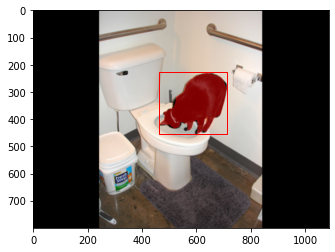

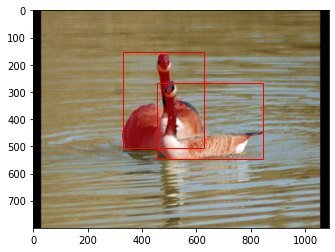

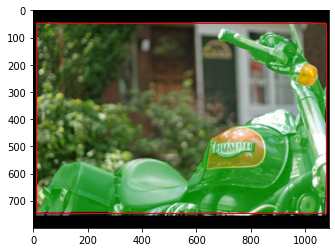

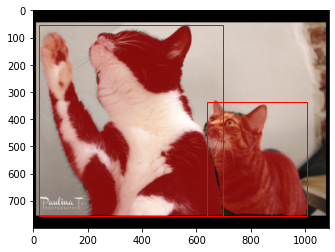

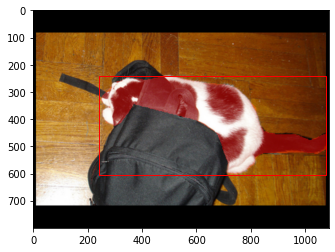

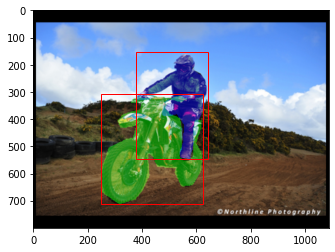

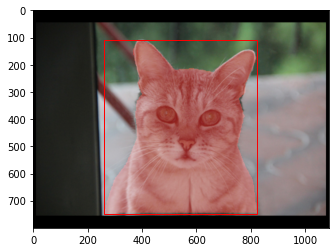

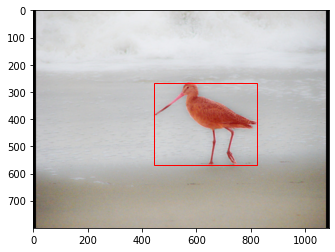

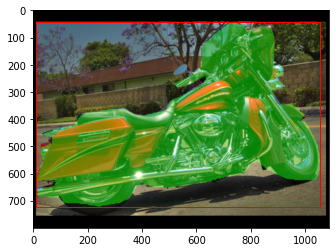

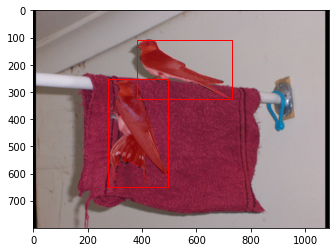

In [21]:
for i in range(len(my_dataset_vis)):
  img=visualise_new(my_dataset_vis[i][0].numpy(),my_dataset_vis[i][2].numpy(),my_dataset_vis[i][3])
  plt.imshow(img)
  for bbox in my_dataset_vis[i][1]:
    xa=int(bbox[0])
    ya=int(bbox[1])
    xb=int(bbox[2])
    yb=int(bbox[3])
    w=xb-xa
    h=yb-ya
   
    plt.gca().add_patch(Rectangle((xa,ya),w,h,
                    edgecolor='red',
                    facecolor='none',
                    ))
  plt.show()

## pretrained model RPN ka jo unhone diya hain put in the path "path="/content/drive/MyDrive/CIS680/hw4/"

In [22]:
def pretrained_models_680(checkpoint_file,eval=True):
    import torchvision
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)

    if(eval):
        model.eval()

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    backbone = model.backbone
    rpn = model.rpn

    if(eval):
        backbone.eval()
        rpn.eval()

    rpn.nms_thresh=0.6
    checkpoint = torch.load(checkpoint_file,map_location=device)

    backbone.load_state_dict(checkpoint['backbone'])
    rpn.load_state_dict(checkpoint['rpn'])

    return backbone, rpn

In [23]:
pretrained_path="/content/drive/MyDrive/CIS680/hw4/checkpoint680.pth"

In [24]:
backbone, rpn = pretrained_models_680(pretrained_path)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## visualisation of bounding box proposed by RPN

images shape torch.Size([4, 3, 800, 1088])
For the proposals We have a list containing 4 tensors
Each one with shape torch.Size([20, 4])

For the features we have a list of features for each FPN level with shapes
torch.Size([4, 256, 200, 272])
torch.Size([4, 256, 100, 136])
torch.Size([4, 256, 50, 68])
torch.Size([4, 256, 25, 34])
torch.Size([4, 256, 13, 17])


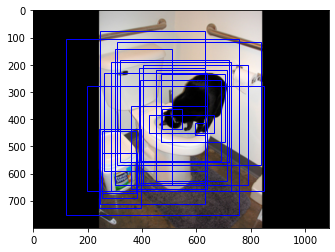

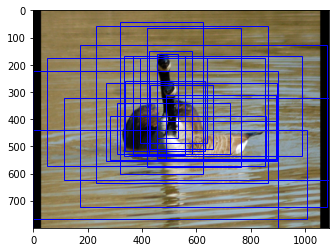

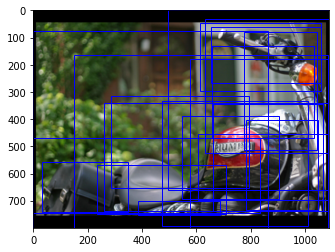

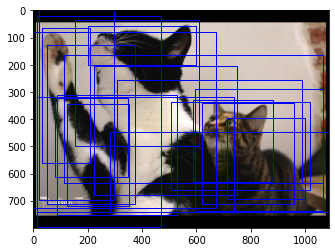

In [25]:
from torchvision.models.detection.image_list import ImageList
import matplotlib.patches as patches
keep_topK=20
iterator_vis=my_dataloader_vis.__iter__()
with torch.no_grad():
  for iter, batch in enumerate(my_dataloader, 0):
      images = batch[0].to(device)
      images_vis=next(iterator_vis)[0]
      print("images shape",images.shape)
      # Take the features from the backbone
      backout = backbone(images)

      # The RPN implementation takes as first argument the following image list
      im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
      # Then we pass the image list and the backbone output through the rpn
      rpnout = rpn(im_lis, backout)

      #The final output is
      # A list of proposal tensors: list:len(bz){(keep_topK,4)}
      proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
      # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
      fpn_feat_list= list(backout.values())

      print("For the proposals We have a list containing "+str(len(proposals))+" tensors")
      print("Each one with shape "+str(proposals[0].shape))
      print("")
      print("For the features we have a list of features for each FPN level with shapes")
      for feat in fpn_feat_list:
          print(feat.shape)


      # Visualization of the proposals
      for i in range(images.shape[0]):
          img_squeeze = images_vis[i]
          fig,ax=plt.subplots(1,1)
          ax.imshow(img_squeeze.permute(1,2,0))


          for box in proposals[i].cpu():
              box=box.view(-1)
              rect=patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],fill=False,color='b')
              ax.add_patch(rect)
          plt.show()

      break


In [39]:
class BoxHead(torch.nn.Module):
    def __init__(self,Classes=3,P=7):
        super(BoxHead,self).__init__()
        self.C=Classes
        self.P=P
        self.device = torch.device("cuda:0" if use_cuda else "cpu")
       
        
        self.intermediate_layer = nn.Sequential(
            nn.Linear(in_features=256*self.P*self.P,out_features = 1024),
            nn.ReLU(),
            nn.Linear(in_features=1024,out_features = 1024),
            nn.ReLU())
        
        ## no softmax kyunki losss mein hain softmax pytorch ke while inference alag se laga lena softmax
        self.class_head_layer = nn.Sequential( 
            nn.Linear(in_features=1024,out_features = self.C+1)
            # nn.Softmax(dim=-1)
        )

        self.regressor_head_layer = nn.Sequential( 
            nn.Linear(in_features=1024,out_features = 4*self.C)
        )
        # TODO initialize BoxHead



    #  This function assigns to each proposal either a ground truth box or the background class (we assume background class is 0)
    #  Input:
    #       proposals: list:len(bz){(per_image_proposals,4)} ([x1,y1,x2,y2] format)
    #       gt_labels: list:len(bz) {(n_obj)}
    #       bbox: list:len(bz){(n_obj, 4)}
    #  Output: (make sure the ordering of the proposals are consistent with MultiScaleRoiAlign)
    #       labels: (total_proposals,1) (the class that the proposal is assigned)
    #       regressor_target: (total_proposals,4) (target encoded in the [t_x,t_y,t_w,t_h] format)
    def create_ground_truth(self,proposals,gt_labels,bbox):
      labels = []
      regressor_target=[]
      for batch_id in range(len(proposals)):
          bbox_batch_id=torch.from_numpy(bbox[batch_id])
          gt_labels_batch_id=torch.from_numpy(gt_labels[batch_id])
          iou= torchvision.ops.box_iou(proposals[batch_id], bbox_batch_id)                     
          box    = torch.zeros((proposals[batch_id].shape[0],4))
          max_iou, gt_box_index = torch.max(iou, dim=1)             
          lables_batch = torch.zeros(proposals[batch_id].shape[0]).float()                 
          lables_batch[max_iou>0.5] =  gt_labels_batch_id[gt_box_index[max_iou>0.5]].float()     
          gt_box = bbox_batch_id[gt_box_index,:]
          box[:,0] = ((gt_box[:,0] + gt_box[:,2])/2 - (proposals[batch_id][:,0]+proposals[batch_id][:,2])/2)/(proposals[batch_id][:,2]-proposals[batch_id][:,0])
          box[:,1] = ((gt_box[:,1] + gt_box[:,3])/2 - (proposals[batch_id][:,1]+proposals[batch_id][:,3])/2)/(proposals[batch_id][:,3]-proposals[batch_id][:,1])
          box[:,2] = torch.log((gt_box[:,2] - gt_box[:,0])/ (proposals[batch_id][:,2] - proposals[batch_id][:,0]))
          box[:,3] = torch.log((gt_box[:,3] - gt_box[:,1])/ (proposals[batch_id][:,3] - proposals[batch_id][:,1]))
          
          labels.append(lables_batch)
          regressor_target.append(box)
          
      labels = torch.hstack(labels).reshape(-1,1)                      
      regressor_target = torch.vstack(regressor_target)               
          
      return labels,regressor_target

       


    # This function for each proposal finds the appropriate feature map to sample and using RoIAlign it samples
    # a (256,P,P) feature map. This feature map is then flattened into a (256*P*P) vector
    # Input:
    #      fpn_feat_list: list:len(FPN){(bz,256,H_feat,W_feat)}
    #      proposals: list:len(bz){(per_image_proposals,4)} ([x1,y1,x2,y2] format)
    #      P: scalar
    # Output:
    #      feature_vectors: (total_proposals, 256*P*P)  (make sure the ordering of the proposals are the same as the ground truth creation)
    def MultiScaleRoiAlign(self, fpn_feat_list,proposals,P=7):
        #####################################
        # Here you can use torchvision.ops.RoIAlign check the docs
        #####################################
        fpn_boxes = [[],[],[],[]]           #For each level of feature pyramid
        orig_height= 800 
        orig_width = 1088
        feature_vectors=[]

        for i in range(len(proposals)):
            for j in range(proposals[i].shape[0]):
                x1,y1,x2,y2 = proposals[i][j]
                w = x2-x1
                h = y2-y1
                k = torch.clip(torch.floor(4+torch.log2(torch.sqrt(w*h)/224)),2,5).int()
            
                fpn_x = fpn_feat_list[k-2].shape[3]
                fpn_y = fpn_feat_list[k-2].shape[2]

                scaled_bbox = proposals[i][j].reshape(1,-1).clone()
                scaled_bbox[:,0] = scaled_bbox[:,0] * fpn_x/ orig_width 
                scaled_bbox[:,2] = scaled_bbox[:,2] * fpn_x/ orig_width
                scaled_bbox[:,1] = scaled_bbox[:,1] * fpn_y/ orig_height
                scaled_bbox[:,3] = scaled_bbox[:,3] * fpn_y/ orig_height


                feature_pyramid_output = fpn_feat_list[k-2][i].unsqueeze(0)  # dim: (1,256,H_feat,W_feat)
                op_aligned  = torchvision.ops.roi_align(feature_pyramid_output, [scaled_bbox.to(self.device)], output_size=(P,P))
                feature_vectors.append(op_aligned.flatten())
              
        
        feature_vectors = torch.stack(feature_vectors, dim=0) #dim = (total_proposals, 256*P*P)
        
        return feature_vectors


    # This function decodes the output of the box head that are given in the [t_x,t_y,t_w,t_h] format
    # into box coordinates where it return the upper left and lower right corner of the bbox
    # Input:
    #       regressed_boxes_t: (total_proposals,4) ([t_x,t_y,t_w,t_h] format)
    #       flatten_proposals: (total_proposals,4) ([x1,y1,x2,y2] format)
    # Output:
    #       box: (total_proposals,4) ([x1,y1,x2,y2] format)
    def output_decoding(self, regressed_boxes_t,flatten_proposals, device='cpu'):  
      boxes_pred = torch.tensor(regressed_boxes_t).to(device)
      proposals = torch.tensor(flatten_proposals).to(device)
      xyxy_box = torch.zeros_like(boxes_pred)
      width_porposal=torch.abs(torch.tensor(proposals[:,0] - proposals[:,2]))
      height_proposal=torch.abs(torch.tensor(proposals[:,1] - proposals[:,3]))
      cx_proposal=(proposals[:,0] + proposals[:,2])/2
      cy_proposal=(proposals[:,1] + proposals[:,3])/2
      
      
      w = width_porposal*torch.exp(boxes_pred[:,2])
      h = height_proposal*torch.exp(boxes_pred[:,3])
      cx = boxes_pred[:,0]*width_porposal + cx_proposal
      cy = boxes_pred[:,1]*height_proposal + cy_proposal
      
      xyxy_box[:,0] = torch.clip(cx - w/2,min = 0)
      xyxy_box[:,1] = torch.clip(cy - h/2,min = 0)
      xyxy_box[:,2] = torch.clip(cx + w/2,max = 1088)
      xyxy_box[:,3] = torch.clip(cy + h/2,max = 800)
        
      return xyxy_box

    # Input:
    #       clas: (top_k_boxes) (scores of the top k boxes)
    #       prebox: (top_k_boxes,4) (coordinate of the top k boxes)
    # Output:
    #       nms_clas: (Post_NMS_boxes)
    #       nms_prebox: (Post_NMS_boxes,4)
    def NMS(self,clas,prebox,labels, thresh):
        ##################################
        # TODO perform NSM
        ##################################
      from copy import deepcopy
      bbox_sorted=deepcopy(prebox.detach().cpu())
      # print(bbox_sorted.shape)
      conf_sorted=deepcopy(clas.detach().cpu())
      label_sorted=deepcopy(labels.detach().cpu())
      nms_prebox=[]
      nms_clas=[]
      nms_label=[]
      bbox_sorted=list(bbox_sorted.numpy())
      conf_sorted=list(conf_sorted.numpy())
      label_sorted=list(label_sorted.numpy())
      # print(len(bbox_sorted))

      while len(bbox_sorted)!=0:
        curr_bbox=bbox_sorted[0]
        curr_conf=conf_sorted[0]
        curr_label=label_sorted[0]
        bbox_sorted.remove(curr_bbox)
        conf_sorted.remove(curr_conf)
        label_sorted.remove(curr_label)
        nms_prebox.append(curr_bbox)
        nms_clas.append(curr_conf)
        nms_label.append(curr_label)
        import sys
        for id,diff_boxes in enumerate(bbox_sorted):
          if(torchvision.ops.box_iou(torch.from_numpy(curr_bbox).reshape(1,4),torch.from_numpy(diff_boxes).reshape(1,4))[0]>0.5):
            del bbox_sorted[id]
            del conf_sorted[id]
            del label_sorted[id]
      return np.array(nms_clas),np.array(nms_prebox), np.array(nms_label)


    # This function does the post processing for the results of the Box Head for a batch of images
    # Use the proposals to distinguish the outputs from each image
    # Input:
    #       class_logits: (total_proposals,(C+1))
    #       box_regression: (total_proposal,4*C)           ([t_x,t_y,t_w,t_h] format)
    #       proposals: list:len(bz)(per_image_proposals,4) (the proposals are produced from RPN [x1,y1,x2,y2] format)
    #       conf_thresh: scalar
    #       keep_num_preNMS: scalar (number of boxes to keep pre NMS)
    #       keep_num_postNMS: scalar (number of boxes to keep post NMS)
    # Output:
    #       boxes: list:len(bz){(post_NMS_boxes_per_image,4)}  ([x1,y1,x2,y2] format)
    #       scores: list:len(bz){(post_NMS_boxes_per_image)}   ( the score for the top class for the regressed box)
    #       labels: list:len(bz){(post_NMS_boxes_per_image)}   (top class of each regressed box)
    def postprocess_detections(self, class_logits, box_regression, proposals, conf_thresh=0.2, keep_num_preNMS=10, keep_num_postNMS=5, keep_topK=200):
      boxes = []
      scores = []
      labels = []
      prenms_boxes = []
      prenms_scores = []
      prenms_labels = []
      batch = len(proposals)
      for b in range(batch):
        clogit_int = class_logits[b*keep_topK: (b+1)*keep_topK,:].detach().cpu().numpy()
        box_int = box_regression[b*keep_topK: (b+1)*keep_topK,:].detach().cpu().numpy()
        pint = proposals[b]
        clogit_max = np.max(clogit_int, axis=1)
        clogit_argmax = np.argmax(clogit_int, axis=1)
        mask = np.logical_and(clogit_max>conf_thresh, clogit_argmax>0) #get non zero eles above thresh
        ckeep = clogit_max[mask]
        clabel = clogit_argmax[mask]
        bkeep = box_int[mask]
        propkeep = pint[mask,:]
        ke = min(keep_num_preNMS, len(ckeep))
        reind = np.argsort(-ckeep) #sort in descending order
        reind = reind[:ke] #keep only keep_num_preNMS boxes after sorting and before nms
        propkeep = propkeep[reind,:]
        bkeep = bkeep[reind]
        ckeep = ckeep[reind]
        clabel = clabel[reind]
        #now for remaining boxes, do NMS
        #before that get the edges for the
        box_reang = np.zeros((len(bkeep), 4))
        for j in range(len(bkeep)):
          box_reang[j,:] = bkeep[j, (clabel[j]-1)*4:(clabel[j]-1)*4+4]
        box_edges = self.output_decoding(box_reang, propkeep)
        prenms_boxes.append(box_edges)
        prenms_scores.append(ckeep)
        prenms_labels.append(clabel)
        nms_class, nms_bboxes, nms_labels = self.NMS(torch.from_numpy(ckeep).to(device), box_edges,torch.from_numpy(clabel), 0.5)
        after_ke = min(keep_num_postNMS, len(nms_class))
        scores.append(nms_class[:after_ke])
        labels.append(nms_labels[:after_ke])
        boxes.append(nms_bboxes[:after_ke,:])
      #each append is everything related to one single image
      return boxes, scores, labels, prenms_boxes, prenms_scores, prenms_labels




    # Compute the total loss of the classifier and the regressor
    # Input:
    #      class_logits: (total_proposals,(C+1)) (as outputed from forward, not passed from softmax so we can use CrossEntropyLoss)
    #      box_preds: (total_proposals,4*C)      (as outputed from forward)
    #      labels: (total_proposals,1)
    #      regression_targets: (total_proposals,4)
    #      l: scalar (weighting of the two losses)
    #      effective_batch: scalar
    # Outpus:
    #      loss: scalar
    #      loss_class: scalar
    #      loss_regr: scalar
    def compute_loss(self,class_logits, box_preds, labels, regression_targets,l=1,effective_batch=150):
      # print(box_preds.shape)
      # print(labels.shape)
      loss = nn.CrossEntropyLoss()
      reg_loss = nn.SmoothL1Loss()
      labels = labels.type(torch.LongTensor).to(device).squeeze()
      label_no_back = (labels!=0).nonzero().squeeze()
      label_back = (labels==0).nonzero().squeeze()
      vals = min(label_no_back.shape[0], int(effective_batch*3/4))
      vals_back = min(label_back.shape[0], int(effective_batch*1/4))
      class_inds = torch.randperm(label_no_back.shape[0])[:vals] #get permuted range of values
      class_inds = label_no_back[class_inds] #get indices where its non zero
      class_inds_back = torch.randperm(label_back.shape[0])[:vals_back]
      class_inds_back = label_back[class_inds_back]
      class_pvals, gt_pvals =  class_logits[class_inds], labels[class_inds] #use it to get the actual non-zero labels
      box_preds_noback, gtbox_preds_noback = box_preds[class_inds,:], regression_targets[class_inds,:].to(device)
      class_pvals_back, gt_pvals_back =  class_logits[class_inds_back], labels[class_inds_back]
      
      loss_class_noback = loss(class_pvals, gt_pvals)
      loss_class_back = loss(class_pvals_back, gt_pvals_back)
      loss_class = loss_class_noback+loss_class_back

      get_corrds_low, get_corrds_high = ((gt_pvals-1)*4).int(), ((gt_pvals-1)*4+4).int()

      loss_regr = 0
      for i in range(get_corrds_low.shape[0]):
        pred_box = box_preds_noback[:, get_corrds_low[i]:get_corrds_high[i]]
        act_box = gtbox_preds_noback[i]
        # print()
        loss_regr += reg_loss(pred_box, act_box)
      
      loss_regr /= get_corrds_low.shape[0]
      loss = l*loss_regr + loss_class
      
      return loss, loss_class, loss_regr



    # Forward the pooled feature vectors through the intermediate layer and the classifier, regressor of the box head
    # Input:
    #        feature_vectors: (total_proposals, 256*P*P)
    # Outputs:
    #        class_logits: (total_proposals,(C+1)) (we assume classes are C classes plus background, notice if you want to use
    #                                               CrossEntropyLoss you should not pass the output through softmax here)
    #        box_pred:     (total_proposals,4*C)
    def forward(self, feature_vectors):
        
        feature_vec_output = self.intermediate_layer(feature_vectors)
        class_logits_without_softmax = self.class_head_layer(feature_vec_output)
        box_pred = self.regressor_head_layer(feature_vec_output)
        
        return class_logits_without_softmax, box_pred

In [27]:
import sys
from tqdm import tqdm
train_loss = []
train_loss_c = []
train_loss_r = []
eval_loss = []
eval_loss_c = []
eval_loss_r = []

In [28]:
from torchvision.models.detection.image_list import ImageList
import matplotlib.patches as patches
boxHead=BoxHead().to(device)
optimizer = torch.optim.Adam(boxHead.parameters(), lr = 0.001)
keep_topK=200
print("The top k proposals that we are taking are",keep_topK)
epochs = 10
boxHead.train()
for i in range(epochs):
  run_loss = 0
  run_loss_c = 0
  run_loss_r = 0
  for iter, batch in enumerate(my_dataloader, 0):
    # print("batch_num",iter)
    # print("each batch has this number of images", batch[0].shape[0])
    images = batch[0].to(device)
    gt_label=batch[1]
    bbox=batch[3]

    backout = backbone(images)
    ## no logixx
    im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
    rpnout = rpn(im_lis, backout)
    # print(len(rpnout[0][0]))
    proposals=[proposal[0:keep_topK,:].cpu() for proposal in rpnout[0]] 
    #proposals had propo?sal for 4 different images and each image has 10 proposals.
    labels, regressor_target = boxHead.create_ground_truth(proposals, gt_label, bbox)
    fpn_feat_list= list(backout.values())
    feature_vectors=boxHead.MultiScaleRoiAlign(fpn_feat_list,proposals)
    # print(feature_vectors.shape)
    class_pred_without_softmax,box_pred=boxHead.forward(feature_vectors.detach()) ## detach is important to stop gradient flow we only want box head and classifier head to train
    #get loss and train now
    optimizer.zero_grad()

    loss, lclass, lreg = boxHead.compute_loss(class_pred_without_softmax, box_pred, labels, regressor_target)
    run_loss += loss.item()
    run_loss_c += lclass.item()
    run_loss_r += lreg.item()    
    loss.backward()
    optimizer.step()
    del class_pred_without_softmax, box_pred
    torch.cuda.empty_cache()

  print("avg loss at epoch", i, "is: ", run_loss/len(my_dataloader))
  train_loss.append(run_loss/len(my_dataloader))
  train_loss_c.append(run_loss_c/len(my_dataloader))
  train_loss_r.append(run_loss_r/len(my_dataloader))



The top k proposals that we are taking are 200


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:922: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([43, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:922: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([42, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:922: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([15, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the

avg loss at epoch 0 is:  8.223737875620523
avg loss at epoch 1 is:  4.585279146830241
avg loss at epoch 2 is:  1.77371084690094
avg loss at epoch 3 is:  0.9685504337151846
avg loss at epoch 4 is:  0.5331611235936483
avg loss at epoch 5 is:  0.3396049340565999
avg loss at epoch 6 is:  0.2688390413920085
avg loss at epoch 7 is:  0.24663799007733664
avg loss at epoch 8 is:  0.1833597073952357
avg loss at epoch 9 is:  0.18479339281717935


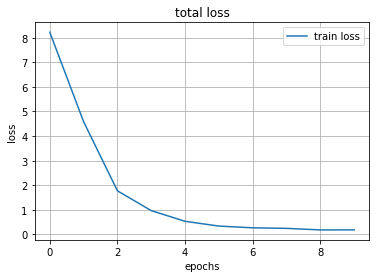

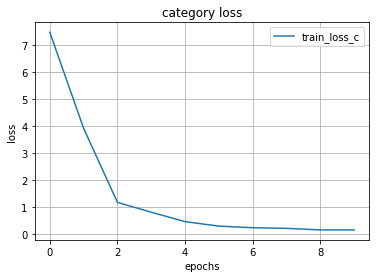

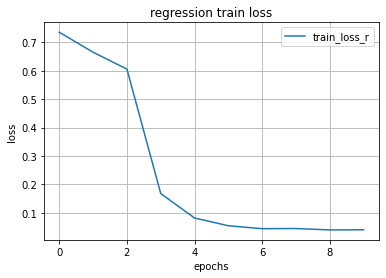

In [29]:
plt.plot(train_loss, label='train loss')
# plt.plot(eval_loss, label='eval loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("total loss")
plt.legend()
plt.grid()
plt.show()
plt.plot(train_loss_c, label='train_loss_c')
# plt.plot(eval_loss_c, label='eval_loss_c')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("category loss")
plt.legend()
plt.grid()
plt.show()
plt.plot(train_loss_r, label='train_loss_r')
# plt.plot(eval_loss_r, label='eval_loss_r')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("regression train loss")
plt.legend()
plt.grid()
plt.show()

In [31]:
path = '/content/drive/MyDrive/CIS680/hw4/divyanshu.pth'
torch.save({
  'model_state_dict': boxHead.state_dict(),
  'optimizer_state_dict': optimizer.state_dict()
  }, path)

In [40]:
path = '/content/drive/MyDrive/CIS680/hw4/divyanshu.pth'
checkpoint = torch.load(path)
boxHead=BoxHead().to(device)
boxHead.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

# Inference Pipeline

The top k proposals that we are taking are 200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


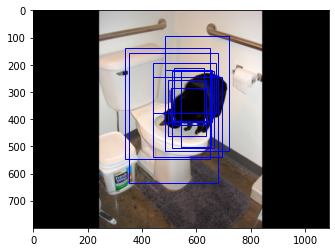

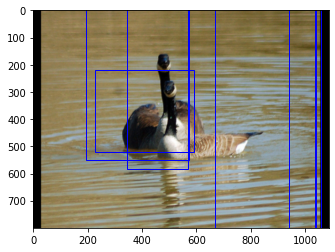

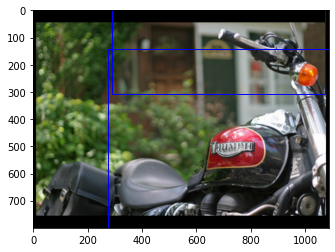

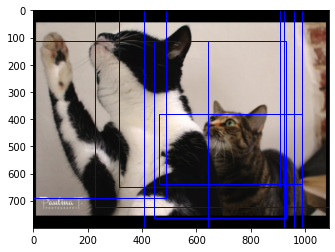

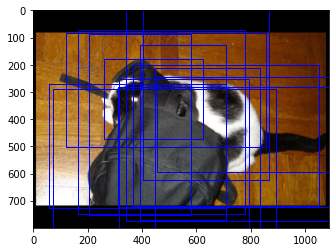

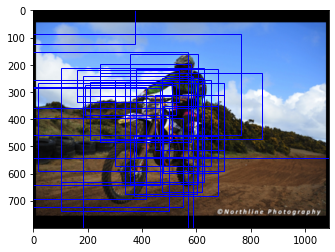

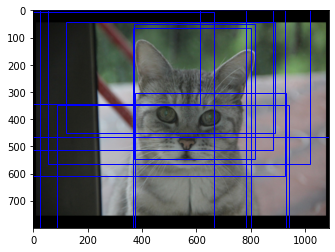

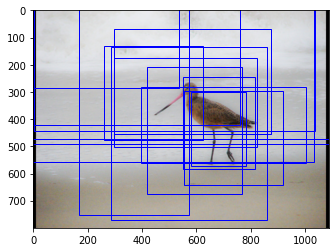

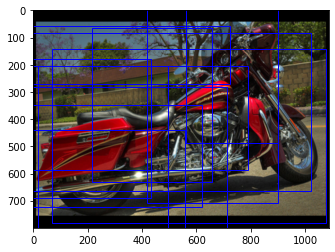

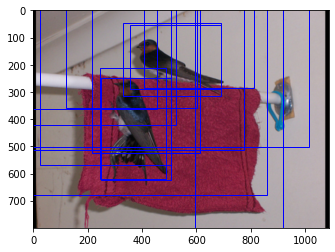

In [50]:
from torchvision.models.detection.image_list import ImageList
import matplotlib.patches as patches
keep_topK=200
print("The top k proposals that we are taking are",keep_topK)
# epochs = 20
# boxHead=BoxHead().to(device)
boxHead.eval()
softmax = nn.Softmax()
with torch.no_grad():
  for iter, batch in enumerate(my_dataloader, 0):
    # print("batch_num",iter)
    # print("each batch has this number of images", batch[0].shape[0])
    images = batch[0].to(device)
    gt_label=batch[1]
    bbox=batch[3]
    backout = backbone(images)
    ## no logixx
    im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
    rpnout = rpn(im_lis, backout)
    # print(len(rpnout[0][0]))
    proposals=[proposal[0:keep_topK,:].cpu() for proposal in rpnout[0]]
    
    # print(proposals[0].shape)
    #proposals had propo?sal for 4 different images and each image has 10 proposals.
    fpn_feat_list= list(backout.values())
    feature_vectors=boxHead.MultiScaleRoiAlign(fpn_feat_list,proposals)
    # print(feature_vectors.shape)
    class_pred_without_softmax,box_pred=boxHead.forward(feature_vectors.detach()) ## detach is important to stop gradient flow we only want box head and classifier head to train
    #get loss and train now
    cls_soft = softmax(class_pred_without_softmax)

    bxes, sores, lbels, prenms_b, prenms_s, prenms_l =boxHead.postprocess_detections(cls_soft, box_pred, proposals)
    cls_with_softmax, max_indices = torch.max(cls_soft,dim=1)

    # print(box_pred.shape)
    # Visualization of the proposals
    # iterator_vis=my_dataloader_vis.__iter__()
    # img_vis = next(iterator_vis)[0]

    for i in range(images.shape[0]):
        img_squeeze = images[i].cpu().squeeze()
        # print(img_squeeze.shape)
        fig,ax=plt.subplots(1,1)
        ax.imshow(img_squeeze.permute(1,2,0))
        cls_img, cls_id = cls_with_softmax[i*keep_topK:(i+1)*keep_topK], max_indices[i*keep_topK:(i+1)*keep_topK]
        rpn_proposal = proposals[i]
        proposals_to_show = []
        for j in range(cls_img.shape[0]):
          if(cls_id[j]==0): #i dont care about the backgrounds
            continue
          start_id, end_id = ((cls_id[j]-1)*4).int(), ((cls_id[j]-1)*4+4).int()
          box_ind = box_pred[j]
          edge_ind = (box_ind[start_id:end_id]).cpu()
          edges_by_rpn = (rpn_proposal[j]).cpu()
          tx, ty, tw,th = edge_ind[0], edge_ind[1], edge_ind[2], edge_ind[3]
          xp, yp, wp,hp = (edges_by_rpn[0]+edges_by_rpn[2])/2, (edges_by_rpn[1]+edges_by_rpn[3])/2, edges_by_rpn[2]-edges_by_rpn[0], edges_by_rpn[3]-edges_by_rpn[1]
          x, y, w,h = tx*wp+xp, ty*hp+yp, torch.exp(tw)*wp, torch.exp(th)*hp
          x_up, y_up = x-(w/2), y-(h/2)
          rect=patches.Rectangle((x_up,y_up),w,h,fill=False,color='b')
          ax.add_patch(rect)
        plt.show()   

    del class_pred_without_softmax, box_pred
    torch.cuda.empty_cache()



## MAP calculation

In [42]:
from sklearn.metrics import auc
def average_precision(predictions, targets, iou_threshold=0.5):
    EPS = 1e-15
    matches = []
    scores = []
    class_trues = torch.zeros(1, 3)
    class_true_positives = torch.zeros(1, 3)

    batch_size = len(predictions)
    
    for bidx in range(batch_size):
      match = torch.zeros(predictions[bidx][:,1].shape[0], 3)
      score = torch.zeros(match.shape)
      classwise_total_trues = torch.zeros(1, 3)
      classwise_true_positive = torch.zeros(classwise_total_trues.shape)

      for obj_label in targets[bidx][:,0]:
        classwise_total_trues[0, obj_label.type(torch.long)-1] += 1

      for obj_label in predictions[bidx][:,1]:
        classwise_true_positive[0, obj_label.type(torch.long)-1] += 1

      for i_pred, class_pred in enumerate(predictions[bidx][:,1]):
        class_pred = (class_pred).type(torch.int32)
        class_pred_scalar = int(class_pred.item()) -1
        if class_pred_scalar in targets[bidx][:,0]:
          true_labels = (targets[bidx][:,0] == class_pred).nonzero(as_tuple=False).squeeze(0)
          for true_label in true_labels:
            predicted_box = predictions[bidx][:,2:][i_pred]
            true_box = targets[bidx][:,1:][true_label.item()-1]
            intersection_x1 = max(predicted_box[0], true_box[0])
            intersection_y1 = max(predicted_box[1], true_box[1])
            intersection_x2 = min(predicted_box[2], true_box[2])
            intersection_y2 = min(predicted_box[3], true_box[3])
            predicted_box_area = (predicted_box[2] - predicted_box[0]) * (predicted_box[3] - predicted_box[1])
            true_box_area = (true_box[2] - true_box[0]) * (true_box[3] - true_box[1])
            intersection_area = max((intersection_x2 - intersection_x1), 0) * max((intersection_y2 - intersection_y1), 0)
            union_area = predicted_box_area + true_box_area - intersection_area + EPS
            iou = intersection_area / union_area
            if iou > iou_threshold*0.5:
              match[i_pred, class_pred] = 1
        score[i_pred, class_pred-1] = predictions[bidx][:,0][int(i_pred)]

      matches.append(match)
      scores.append(score)
      class_trues = torch.cat([class_trues, classwise_total_trues], dim=0)
      class_true_positives = torch.cat([class_true_positives, classwise_true_positive], dim=0)

    class_precision = []
    class_recall = []
    class_auc = []
    match_values_all = torch.cat(matches)
    score_values_all = torch.cat(scores)
    total_trues_all = torch.sum(class_trues, dim=0)
    total_positives_all =  torch.sum(class_true_positives, dim=0)
    for class_id in range(3):
      match_values = match_values_all[:, class_id]
      score_values = score_values_all[:, class_id]
      total_trues = total_trues_all[class_id]
      total_positives = total_positives_all[class_id]

      area, sorted_recall, sorted_precision = None, None, None

      max_score = torch.max(score_values).item()
      ln = torch.linspace(0.2, max_score, steps=100)
      precision_mat = torch.zeros(101)
      recall_mat = torch.zeros(101)
      for i, th in enumerate(ln):
        matches = match_values[score_values > th]
        true_positives = torch.sum(matches)  # true positives
        precision = 1
        if total_positives > 0:
          precision = true_positives / total_positives

        recall = 1
        if total_trues > 0:
          recall = true_positives / total_trues

        precision_mat[i] = precision
        recall_mat[i] = recall

      recall_mat[100] = 0
      precision_mat[100] = 1
      sorted_idx = torch.argsort(recall_mat)
      sorted_recall = recall_mat[sorted_idx]
      sorted_precision = precision_mat[sorted_idx]
      area = auc(sorted_recall, sorted_precision)
      class_precision.append(sorted_precision)
      class_recall.append(sorted_recall)
      class_auc.append(area)
    return class_auc, class_recall, class_precision 



def mean_average_precision(predictions, targets):
    # predictions: (N, (score, class_idx, x1, y1, x2, y2))  class_idx = [1, 2, 3] background not included
    # targets: (N, (class_idx, x1, y1, x2, y2))  class_idx = [1, 2, 3] background not included
    ap, recall, precision = average_precision(predictions, targets, 1)
    ap_0, ap_1, ap_2 = ap
    mean_average_precision = (ap_0 + ap_1 + ap_2)/3.0

    return mean_average_precision, ap_0, ap_1, ap_2

In [49]:
from torchvision.models.detection.image_list import ImageList
import matplotlib.patches as patches
keep_topK=200
print("The top k proposals that we are taking are",keep_topK)
# epochs = 20
# boxHead=BoxHead().to(device)
boxHead.eval()
softmax = nn.Softmax()
running_map = 0.
running_ap1 = 0.
running_ap2 = 0.
running_ap3 = 0.
with torch.no_grad():
  for iter, batch in enumerate(my_dataloader, 0):
    # print("batch_num",iter)
    # print("each batch has this number of images", batch[0].shape[0])
    images = batch[0].to(device)
    gt_label=batch[1]
    bbox=batch[3]
    backout = backbone(images)
    ## no logixx
    im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
    rpnout = rpn(im_lis, backout)
    # print(len(rpnout[0][0]))
    proposals=[proposal[0:keep_topK,:].cpu() for proposal in rpnout[0]]
    
    # print(proposals[0].shape)
    #proposals had propo?sal for 4 different images and each image has 10 proposals.
    fpn_feat_list= list(backout.values())
    feature_vectors=boxHead.MultiScaleRoiAlign(fpn_feat_list,proposals)
    # print(feature_vectors.shape)
    class_pred_without_softmax,box_pred=boxHead.forward(feature_vectors.detach()) ## detach is important to stop gradient flow we only want box head and classifier head to train
    #get loss and train now
    cls_soft = softmax(class_pred_without_softmax)

    bxes, sores, lbels, prenms_b, prenms_s, prenms_l =boxHead.postprocess_detections(cls_soft, box_pred, proposals)
    targets = []
    pred_list_for_map=[]
    for batch in range(len(gt_label)):
          temp = torch.zeros((len(gt_label[batch]), 5))
          for i in range(len(gt_label[batch])):
            l = torch.tensor(gt_label[batch][i])
            b = torch.from_numpy(bbox[batch][i])
            temp[i] = torch.stack((l, b[0], b[1], b[2], b[3]))

          targets.append(temp)
    for batch in range(len(bxes)):
          temp = torch.zeros((len(bxes[batch]), 6))
          for i in range(len(bxes[batch])):
            l = torch.tensor(lbels[batch][i])
            b = torch.from_numpy(bxes[batch][i])
            temp[i] = torch.stack((torch.tensor(sores[batch][i]),l, b[0], b[1], b[2], b[3]))

          pred_list_for_map.append(temp)
    map, ap1, ap2, ap3 = mean_average_precision(pred_list_for_map, targets)
    running_map += map
    running_ap1 += ap1
    running_ap2 += ap2
    running_ap3 += ap3

print("\nMean Average Precision: {:.4f}".format(running_map/len(my_dataloader)))
print("Average Precision for Class 1: {:.4f}".format(running_ap1/len(my_dataloader)))
print("Average Precision for Class 2: {:.4f}".format(running_ap2/len(my_dataloader)))
print("Average Precision for Class 3: {:.4f}".format(running_ap3/len(my_dataloader)))

The top k proposals that we are taking are 200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Mean Average Precision: 0.6900
Average Precision for Class 1: 0.8400
Average Precision for Class 2: 0.6100
Average Precision for Class 3: 0.7100


##Post NMS And PRE NMS predictions

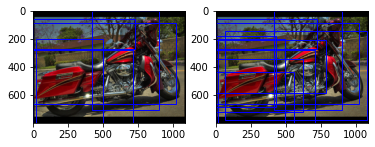

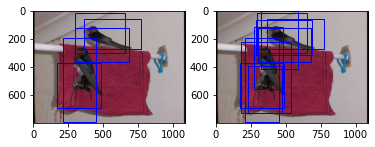

In [37]:
for i in range(len(bxes)):
  img_squeeze = images[i].cpu().squeeze()
  # print(img_squeeze.shape)
  fig,ax=plt.subplots(1,2)
  ax[0].imshow(img_squeeze.permute(1,2,0))
  for bbox in bxes[i]:
    xa=int(bbox[0])
    ya=int(bbox[1])
    xb=int(bbox[2])
    yb=int(bbox[3])
    w=xb-xa
    h=yb-ya
   
    rect=patches.Rectangle((xa,ya),w,h,fill=False,color='b')
    ax[0].add_patch(rect)
  ax[1].imshow(img_squeeze.permute(1,2,0))
  for bbox in prenms_b[i]:
    xa=int(bbox[0])
    ya=int(bbox[1])
    xb=int(bbox[2])
    yb=int(bbox[3])
    w=xb-xa
    h=yb-ya
   
    rect=patches.Rectangle((xa,ya),w,h,fill=False,color='b')
    ax[1].add_patch(rect)
  plt.show()

## visualisation of assignemnet of bounding box proposed by RPN to ground truth bounding box 

images shape torch.Size([4, 3, 800, 1088])


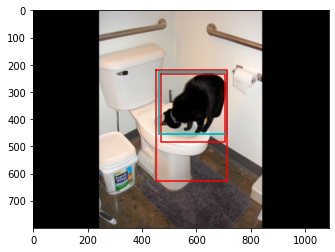

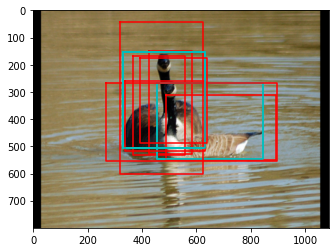

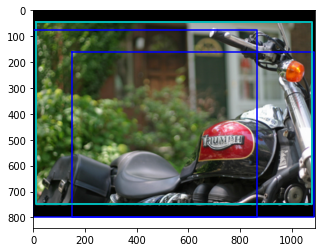

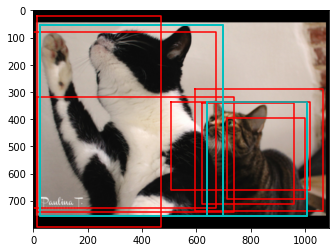

In [ ]:
# Green -> Person --> 2
# Red -> Animal  --> 3
# Blue -> Vehicle  --> 1
boxHead=BoxHead().to(device)
keep_topK=20
iterator_vis=my_dataloader_vis.__iter__()
for iter, batch in enumerate(my_dataloader, 0):
    images = batch[0].to(device)
    images_vis=next(iterator_vis)[0]
    print("images shape",images.shape)
    gt_label=batch[1]
    bbox=batch[3]



    # Take the features from the backbone
    
   

    with torch.no_grad():
    # The RPN implementation takes as first argument the following image list
      im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
      backout = backbone(images)
      # Then we pass the image list and the backbone output through the rpn
      rpnout = rpn(im_lis, backout)


    # A list of proposal tensors: list:len(bz){(keep_topK,4)}
    proposals=[proposal[0:keep_topK,:].cpu() for proposal in rpnout[0]]

    
    labels, regressor_target = boxHead.create_ground_truth(proposals, gt_label, bbox)

    for image_id in range(images.shape[0]):
      
      window_start=image_id*20
      window_end=(image_id+1)*20
      gt_box= torch.zeros(regressor_target[:20,:].shape)
      
      prop = proposals[image_id]
      xp = (prop[:,0] + prop[:,2])/2
      yp = (prop[:,1] + prop[:,3])/2
       
      wp = prop[:,2] - prop[:,0]
      hp = prop[:,3] - prop[:,1]
     
      
      gt_box[:,0] = regressor_target[window_start:window_end,0]*wp + xp - torch.exp(regressor_target[window_start:window_end,2])*wp/2
      gt_box[:,1] = regressor_target[window_start:window_end,1]*hp + yp - torch.exp(regressor_target[window_start:window_end,3])*hp/2
      gt_box[:,2] = regressor_target[window_start:window_end,0]*wp + xp + torch.exp(regressor_target[window_start:window_end,2])*wp/2 
      gt_box[:,3] = regressor_target[window_start:window_end,1]*hp + yp + torch.exp(regressor_target[window_start:window_end,3])*hp/2
      curr_imag_labels=labels[window_start:window_end]
      plt.figure(1)
      plt.imshow(images_vis[image_id,:,:,:].cpu().numpy().transpose(1,2,0))
      for i in range(prop.shape[0]):
        gt_coord = gt_box[i,:]
        prop_coord = prop[i,:]
        if curr_imag_labels[i] == 1:
          plt.plot([ gt_coord[0],  gt_coord[2],  gt_coord[2],  gt_coord[0],  gt_coord[0]], [ gt_coord[1],  gt_coord[1],  gt_coord[3],  gt_coord[3],  gt_coord[1]], 'c-',linewidth=1.5)
          plt.plot([ prop_coord[0],  prop_coord[2],  prop_coord[2],  prop_coord[0],  prop_coord[0]], [ prop_coord[1],  prop_coord[1],  prop_coord[3],  prop_coord[3],  prop_coord[1]], 'b-')
        if curr_imag_labels[i] == 2:
          plt.plot([ gt_coord[0],  gt_coord[2],  gt_coord[2],  gt_coord[0],  gt_coord[0]], [ gt_coord[1],  gt_coord[1],  gt_coord[3],  gt_coord[3],  gt_coord[1]], 'c-',linewidth=1.5)
          plt.plot([ prop_coord[0],  prop_coord[2],  prop_coord[2],  prop_coord[0],  prop_coord[0]], [ prop_coord[1],  prop_coord[1],  prop_coord[3],  prop_coord[3],  prop_coord[1]], 'g-')
        if curr_imag_labels[i] == 3:
          plt.plot([ gt_coord[0],  gt_coord[2],  gt_coord[2],  gt_coord[0],  gt_coord[0]], [ gt_coord[1],  gt_coord[1],  gt_coord[3],  gt_coord[3],  gt_coord[1]], 'c-',linewidth=1.5)
          plt.plot([ prop_coord[0],  prop_coord[2],  prop_coord[2],  prop_coord[0],  prop_coord[0]], [ prop_coord[1],  prop_coord[1],  prop_coord[3], prop_coord[3],  prop_coord[1]], 'r-')
        
      plt.show()
    
    break
    